In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import matplotlib.pyplot as plt
import seaborn as sns
from TwitterDataAnalysis import processing
from nrclex import NRCLex
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import nltk
nltk.download('punkt')

%load_ext autoreload
%autoreload 2
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tabithasugumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("Data/Plastic_10_01.csv")

In [3]:
#deal with row that was scraped incorrectly
df["user_followers_count"] = df["user_followers_count"].apply(pd.to_numeric, errors='coerce')
df.dropna(subset = ["user_followers_count"], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8049 entries, 0 to 8052
Data columns (total 13 columns):
tweet_id                8049 non-null object
tweet                   8049 non-null object
retweets                8049 non-null float64
likes                   8049 non-null float64
user_id                 8049 non-null object
user_name               8049 non-null object
user_followers_count    8049 non-null float64
location                6235 non-null object
datetime                8049 non-null object
hashtags                8049 non-null object
urls                    8049 non-null object
mentions                8049 non-null object
mentions_ids            8049 non-null object
dtypes: float64(3), object(10)
memory usage: 880.4+ KB


#### Exploratory Data Analysis

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


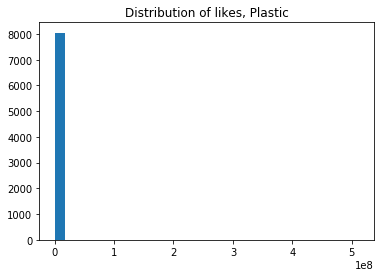

In [3]:
plt.hist(df["likes"], bins = 30)
plt.title("Distribution of likes, Plastic")
plt.show()

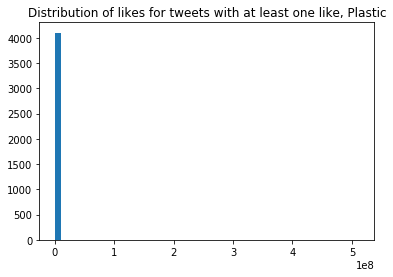

In [4]:
plt.hist(df[df["likes"] > 0]["likes"], bins = 50)
plt.title("Distribution of likes for tweets with at least one like, Plastic")
plt.show()

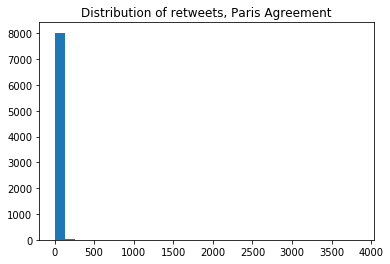

In [5]:
plt.hist(df["retweets"], bins = 30)
plt.title("Distribution of retweets, Paris Agreement")
plt.show()

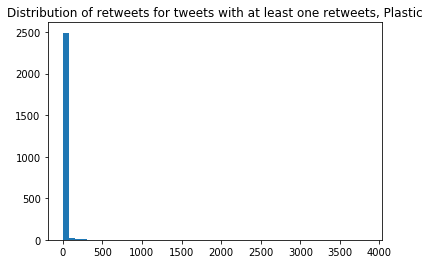

In [6]:
plt.hist(df[df["retweets"] > 0]["retweets"], bins = 50)
plt.title("Distribution of retweets for tweets with at least one retweets, Plastic")
plt.show()

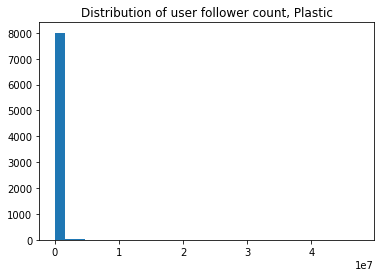

In [26]:
plt.hist(df["user_followers_count"].dropna(), bins = 30)
plt.title("Distribution of user follower count, Plastic")
plt.show()

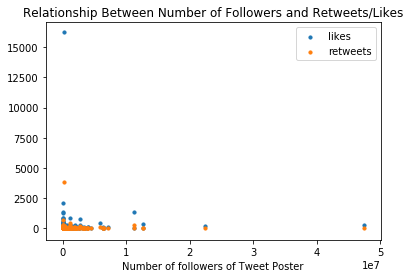

In [25]:
plt.scatter("user_followers_count", "likes", data = df.dropna(subset = ["user_followers_count", "likes"]), label = "likes", s = 10)
plt.scatter("user_followers_count", "retweets", data = df.dropna(subset = ["user_followers_count", "likes"]), label = "retweets", s = 10)
plt.xlabel("Number of followers of Tweet Poster")
plt.title("Relationship Between Number of Followers and Retweets/Likes")
plt.legend()
plt.show()

In [27]:
display(df[df["likes"] > 2000])

,tweet_id,tweet,retweets,likes,user_id,user_name,user_followers_count,location,datetime,hashtags,urls,mentions,mentions_ids
4238,1309598597546205185,One more time for the people in the back: \n\n...,678.0,2122.0,1170057621832777728,No_PlasticWaste,40701.0,Pacific Ocean,2020-09-25 21:00:11,['NoPlasticWaste'],['https://weather.com/en-IN/india/pollution/ne...,[],[]
5233,1308974726547738624,This is how our plastic waste is killing wildl...,3845.0,16240.0,1052325553,ParveenKaswan,211571.0,India,2020-09-24 03:41:09,['beatplasticpollution'],[],[],[]


As expected, for both likes and retweets the vast majority of tweets are liked/favorite very few times and very very few are liked/favorite a huge number of times. It could be interesting to see who are the users that tweet the tweets with high stats. Keeping in mind that more retweets/likes generally means more people see it. However, knowing whether people feel positively or negatively toward the tweet is a very different question.

Regarding the final graph, it seems that the number of followers for this subject isn't strongly affecting the number of likes/retweets. However this may have to do with kind of engagement some users have.

#### Tweeters

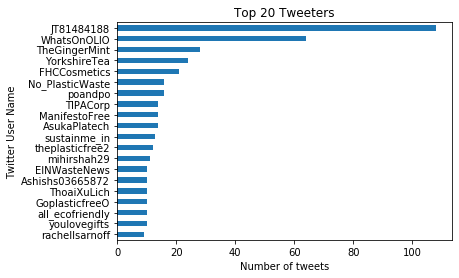

In [28]:
users = df.user_name.value_counts().sort_values()
users[-20:].plot.barh()
plt.title("Top 20 Tweeters")
plt.ylabel("Twitter User Name")
plt.xlabel("Number of tweets")
plt.show()

#### Hashtags

In [4]:
hashtags = processing.get_entities(df)

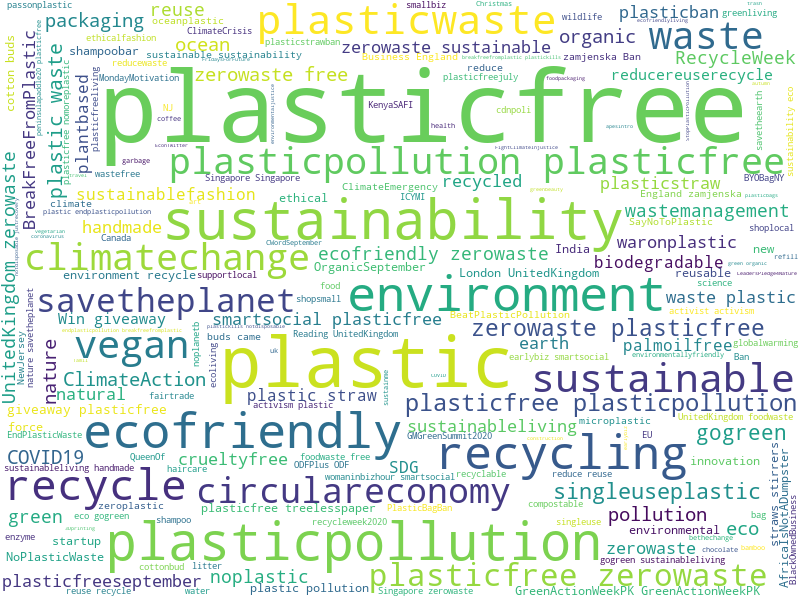

In [5]:
hashtags_cloud = WordCloud(background_color = "white", width = 800, height = 600)
hashtags_cloud.generate(" ".join(hashtags))
hashtags_cloud.to_image()

This dataset was scraped right after the debate, so it's possible that there are tweets where the sentiment has more to do with a reacion to the debate/US 2020 election, but as we continue to collect data it will likely be less of a problem.

#### Mentions

In [31]:
mentions = processing.get_entities(df, "mentions")

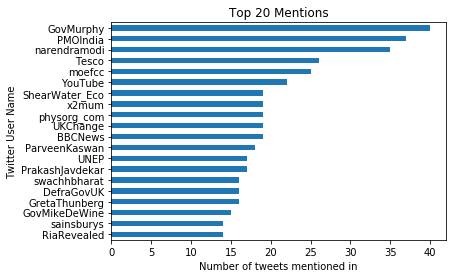

In [32]:
unique_mentions = np.unique(mentions, return_counts = True)
m = pd.Series(unique_mentions[1], index = unique_mentions[0])
m.sort_values()[-20:].plot.barh()
plt.title("Top 20 Mentions")
plt.ylabel("Twitter User Name")
plt.xlabel("Number of tweets mentioned in")
plt.show()

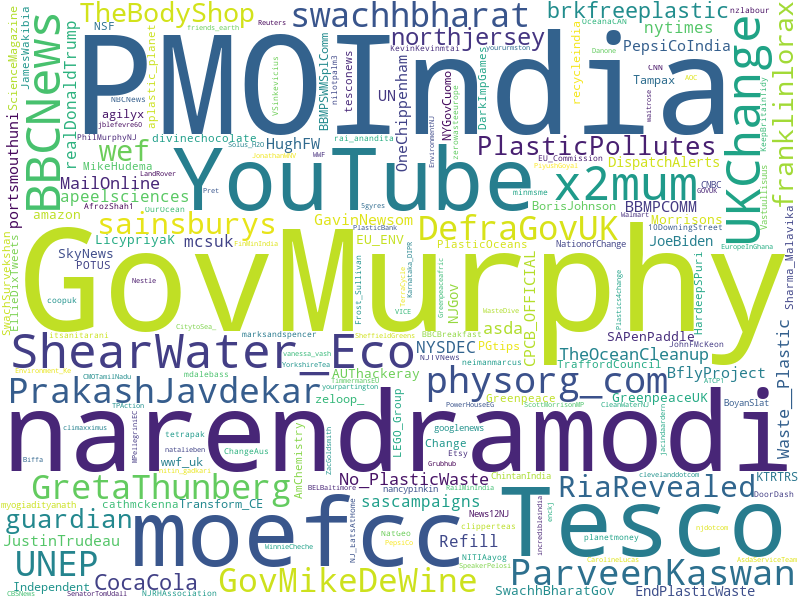

In [33]:
mentions_cloud = WordCloud(background_color = "white", width = 800, height = 600, collocations = False)
mentions_cloud.generate(" ".join(mentions))
mentions_cloud.to_image()

#### Tweets

In [34]:
tweets = df["tweet"].apply(processing.clean_text_lda)

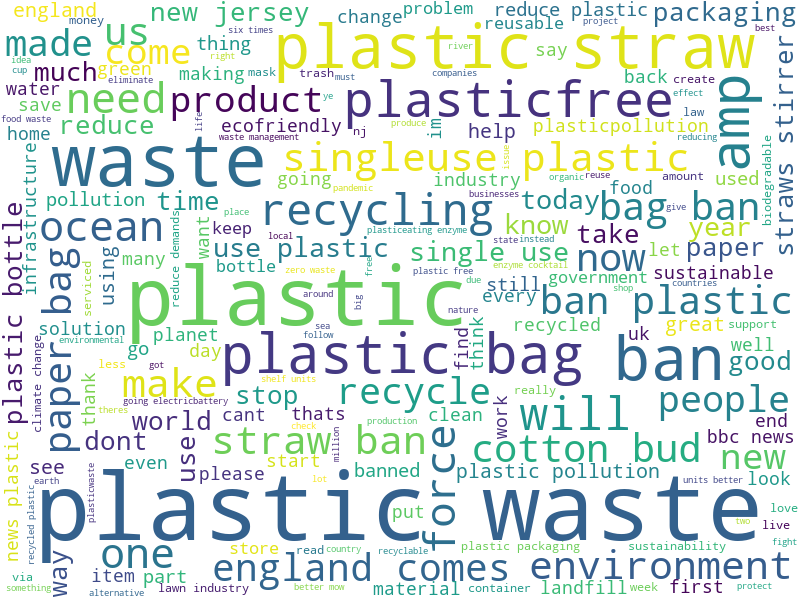

In [35]:
tweets_cloud = WordCloud(background_color = "white", stopwords = STOPWORDS, width = 800, height = 600)
tweets_cloud.generate(" ".join(list(tweets)))
tweets_cloud.to_image()

It's clear that politics is playing a part in these discussions, as well as talk about fossil fues, and funding.

#### LDA

In [36]:
count_vectorizer = CountVectorizer(stop_words = 'english')
tweet_data = count_vectorizer.fit_transform(list(tweets))

In [37]:
number_topics = 4
number_words = 10
lda = LDA(n_components = number_topics, n_jobs = -1)
lda.fit(tweet_data)

LatentDirichletAllocation(n_components=4, n_jobs=-1)

In [38]:
processing.print_top_words(lda, count_vectorizer.get_feature_names(), 20)

Topic #0: plastic waste plasticfree new amp sustainable recycling ecofriendly use sustainability zerowaste recycled packaging help environment enzyme like make just pollution
Topic #1: plastic ban bags waste straws paper england force comes straw singleuse new cotton use buds stirrers news bag today single
Topic #2: plastic waste reduce use industry plasticfree emissions tons better going infrastructure pollution change stop lawn demands units dont shelf electricbattery
Topic #3: plastic waste ban plasticfree amp bag free food zerowaste packaging make way just ocean containers like pollution reduce recycling recycle


In [39]:
pyLDAvis.sklearn.prepare(lda, tweet_data, count_vectorizer)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.056232 -0.066599       1        1  30.638772
1     -0.160149  0.039947       2        1  29.384020
3      0.002558 -0.075314       3        1  20.697823
2      0.101359  0.101966       4        1  19.279384, topic_info=      Category         Freq         Term        Total  loglift  logprob
1311   Default  1933.000000          ban  1933.000000  30.0000  30.0000
1225   Default   888.000000         bags   888.000000  29.0000  29.0000
5973   Default   448.000000      england   448.000000  28.0000  28.0000
7086   Default   422.000000        force   422.000000  27.0000  27.0000
3588   Default   422.000000        comes   422.000000  26.0000  26.0000
...        ...          ...          ...          ...      ...      ...
21579   Topic4    78.295925        water   253.491015   0.4713  -5.7714
15157   Topic4   135.840926  plasticfree  1041.781570  -0.3911  -5.2204
16430   Topic4    80.542712      recycle   298.236340   0.3370  -5.7431
6051    Topic4    77.076157  environment   361.303660   0.1012  -5.7871
16469   Topic4    71.364879    recycling   444.381127  -0.1827  -5.8641

[281 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
147        4  0.903156              activist
149        1  0.060112            activities
149        4  0.931743            activities
302        4  0.903146  africaisnotadumpster
561        1  0.369028                   amp
...      ...       ...                   ...
22189      3  0.513160                 years
22189      4  0.121767                 years
22335      1  0.539963             zerowaste
22335      3  0.391738             zerowaste
22335      4  0.067054             zerowaste

[432 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

#### Overall Sentiment Analysis

In [40]:
nrc = NRCLex(". ".join(list(tweets)))

In [41]:
#Note: Unclear what these counts actually represent (more than the number of tweets (sentences))
display(pd.DataFrame(nrc.raw_emotion_scores.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency")[::-1])

,emotion,frequency
2,positive,77179
0,trust,73598
3,negative,67455
9,fear,61009
4,sadness,60098
7,anger,60012
6,joy,59368
1,anticip,59076
5,disgust,58459
8,surprise,56926


In [42]:
emotion_freq = pd.DataFrame(nrc.affect_frequencies.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency")
emotion_freq = emotion_freq.sort_values(by = "frequency")
display(emotion_freq[::-1])

,emotion,frequency
5,positive,0.121891
3,trust,0.116236
6,negative,0.106534
0,fear,0.096353
7,sadness,0.094915
1,anger,0.094779
9,joy,0.093762
2,anticip,0.093300
8,disgust,0.092326
4,surprise,0.089905


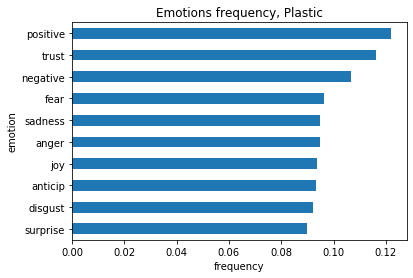

In [43]:
emotion_freq.set_index("emotion").plot.barh(legend = False)
plt.title("Emotions frequency, Plastic")
plt.xlabel("frequency")
plt.ylabel("emotion")
plt.show()

In [44]:
nrc.top_emotions

[('positive', 0.12189108942164945)]

#### Sentiment Analysis with Vader

In [45]:
sa = SentimentIntensityAnalyzer()
sa_results = {tweet:sa.polarity_scores(tweet) for tweet in list(tweets)}
sa_avgs = {val:np.mean([sent[val] for sent in sa_results.values()]) for val in ["neg", "neu", "pos"]}

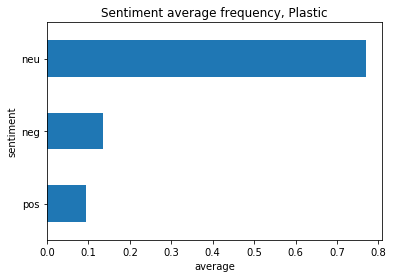

In [46]:
pos_neg_avg = pd.DataFrame(sa_avgs.items(), columns = ["sentiment", "frequency"]).sort_values(by = "frequency")
pos_neg_avg.set_index("sentiment").plot.barh(legend = False)
plt.title("Sentiment average frequency, Plastic")
plt.xlabel("average")
plt.ylabel("sentiment")
plt.show()

In [47]:
display(pos_neg_avg[::-1])

,sentiment,frequency
1,neu,0.770071
0,neg,0.135852
2,pos,0.094080


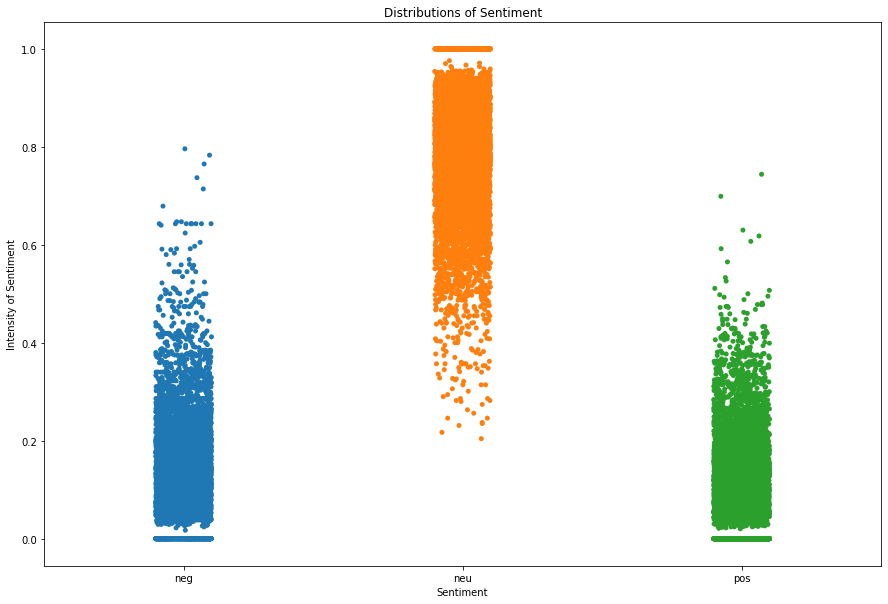

In [57]:
plt.figure(figsize=(15,10))
strp = {val:[sent[val] for sent in sa_results.values()] for val in ["neg", "neu", "pos"]}
strp = pd.DataFrame.from_dict(strp)
sns.stripplot(data = strp)
plt.title("Distributions of Sentiment")
plt.ylabel("Intensity of Sentiment")
plt.xlabel("Sentiment")
plt.show()

#### Sentiment Analysis by Topic
*I'm not very confident about the validity of this since there aren't sentences*
Did not have a chance to run this because of the size of the dataset

In [50]:
# topics = []
# for idx, topic in enumerate(lda.components_):
#     topics.append([count_vectorizer.get_feature_names()[i] for i in topic.argsort()[:-len(topic) - 1:-1]])

In [49]:
# fig, ax = plt.subplots(1,len(topics), figsize = (15, 10))
# for i in range(len(topics)):
#     nrc = NRCLex(" ".join(topics[i]))
#     emotion_freq = pd.DataFrame(nrc.affect_frequencies.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency").set_index("emotion")
#     emotion_freq.plot.barh(ax = ax[i], legend = False)
#     ax[i].set_title("Emotions frequency, topic {}".format(str(i)))
#     ax[i].set_xlabel("frequency")
#     ax[i].set_ylabel("emotion")
#     plt.tight_layout()